In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import signac
import cg_pyrosetta
import numpy as np
import pandas as pd
import copy
import os
import flow
import analyze_foldamers
import matplotlib.pyplot as plt
import mdtraj as md
from flow import FlowProject
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size" : 15})

In [105]:
project = signac.get_project()
schema = project.detect_schema()
repsm, sc_sizes= schema.items()
sc_sizes = list(sc_sizes[1][float])
sc_sizes

[0.8888888888888888,
 1.2777777777777777,
 0.5,
 3.611111111111111,
 3.2222222222222223,
 4.0,
 1.6666666666666667,
 2.0555555555555554,
 2.8333333333333335,
 2.4444444444444446]

In [106]:
for sc_size in sc_sizes:
    print("SC Size = " + str(round(sc_size, 4)))
    for job in project.find_jobs({'sc_size':sc_size}):
        print(job.id)

SC Size = 0.8889
ed81dcdfa4af8d1c6e1e6481ddac5743
65e7b178723734fb7c55a5337e69d615
95ee171b53b777c2aed2d7364bd5dbb3
9adcc5f48f5d700fb94f7ba0592bbee8
f12a2cb3cfff06cf4573922ea3b98529
c0b2316cbe931c759a1a7e56387888c6
d91f1c6ae339cffa3f798a889b69cd41
c90409b6d2fd15c7602c1e390ab2893d
15089bc948364599c2f84031c06899da
f0abfefdc8d6128e00b02cf1cbdfdaeb
SC Size = 1.2778
dc4edc98b0c6928ba9fa761d139a1ef3
6154abc193420083fe96f1bb66cf49fc
ec6ab16b3b8cc283ff6b65e6eaedd4cb
e3509b9973e779c7ed597fe7d9683a87
535c9e728f4121f92529482b1c633146
80fe9abe932018c5bdd4776fe00684a6
be11df5dc50cdec4e4170490cd4afa82
18502432d5fc304f1309588fb5ccd8ba
922fdfef0d08ecb83b867e37b9bdf687
865c7179b32d9a3fbe287bbeef99c22c
SC Size = 0.5
71558c039e9eb1003940f66f9115b15c
21751d80204d43046ec9173557795a83
ef42543d532bd8ca561f383b7e20b56c
01a33184356aca40482e6f4ca8238480
fbc6c8b7530a44f4892b977fc884dfd8
21353b019fd1e8f924ee877197abd90e
43b0e9c3abae925136fecf64bcb1c762
6016baf97d0160c6174dc0587d2aa81d
09eca16ec26de9ac06ba1eb279b5

In [107]:
kts = np.array([5 * ( 0.9 ) ** i for i in range(50)])
out_steps = np.array([10000 * i for i in range(50) ])

sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 0.8888888888888888 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 1.2777777777777777 hasn't started yet
sc_size 0.5 hasn't started yet
sc_size 0.5 hasn't started yet
sc_size 0.5 hasn't started yet
sc_size 0.5 hasn't started yet
sc_size 0.5 hasn't started yet
sc_size 0.5 hasn'

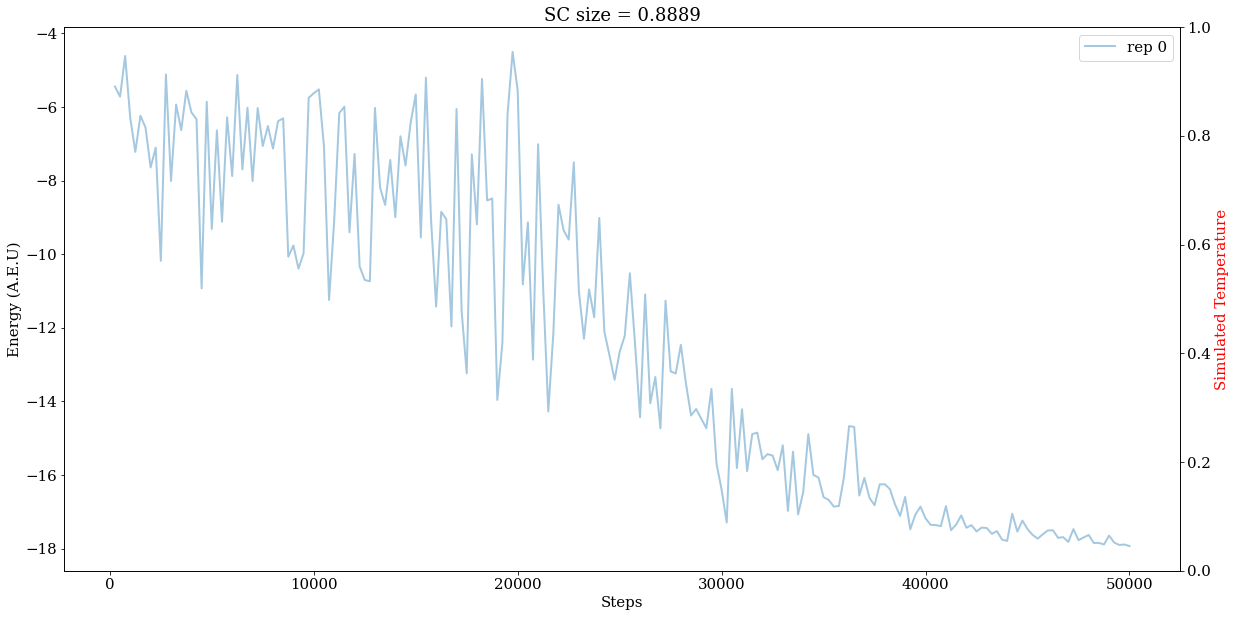

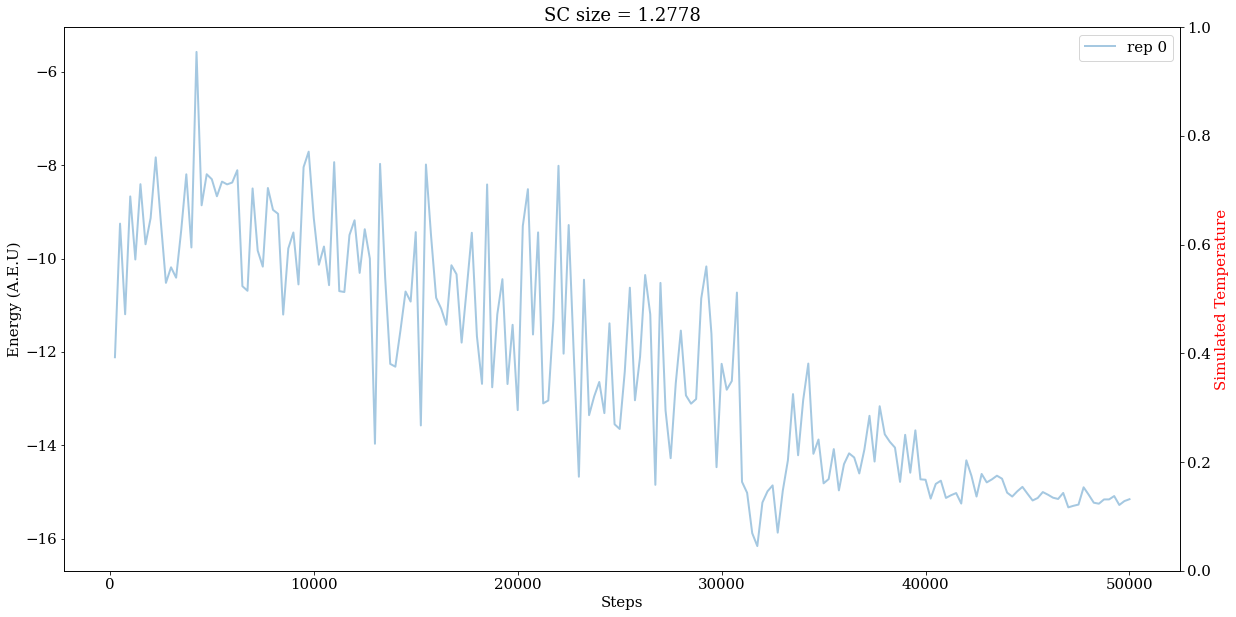

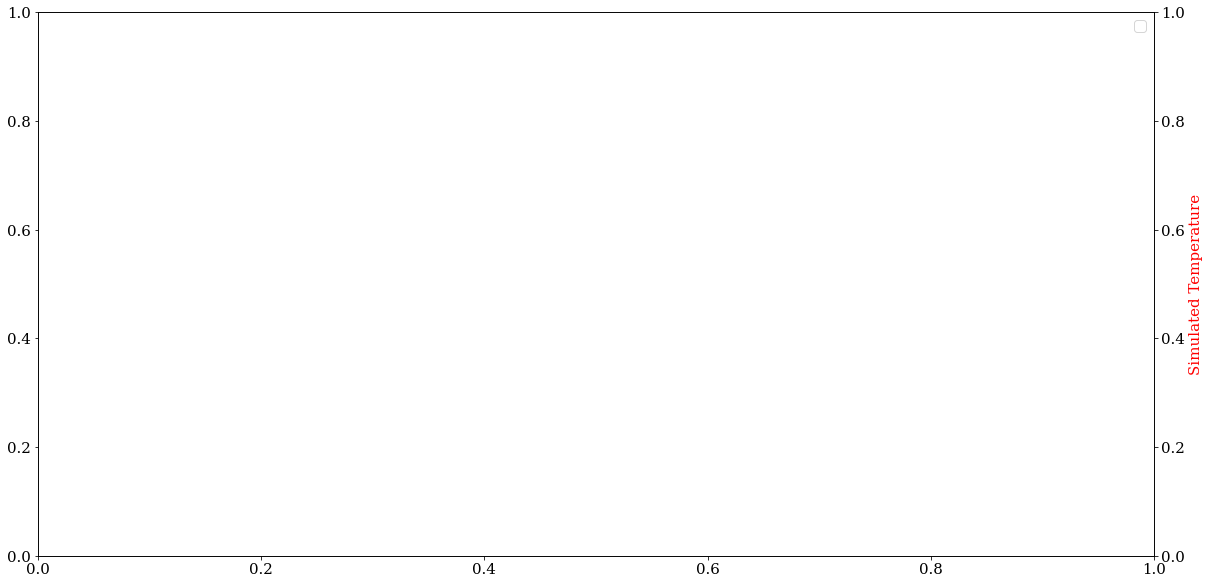

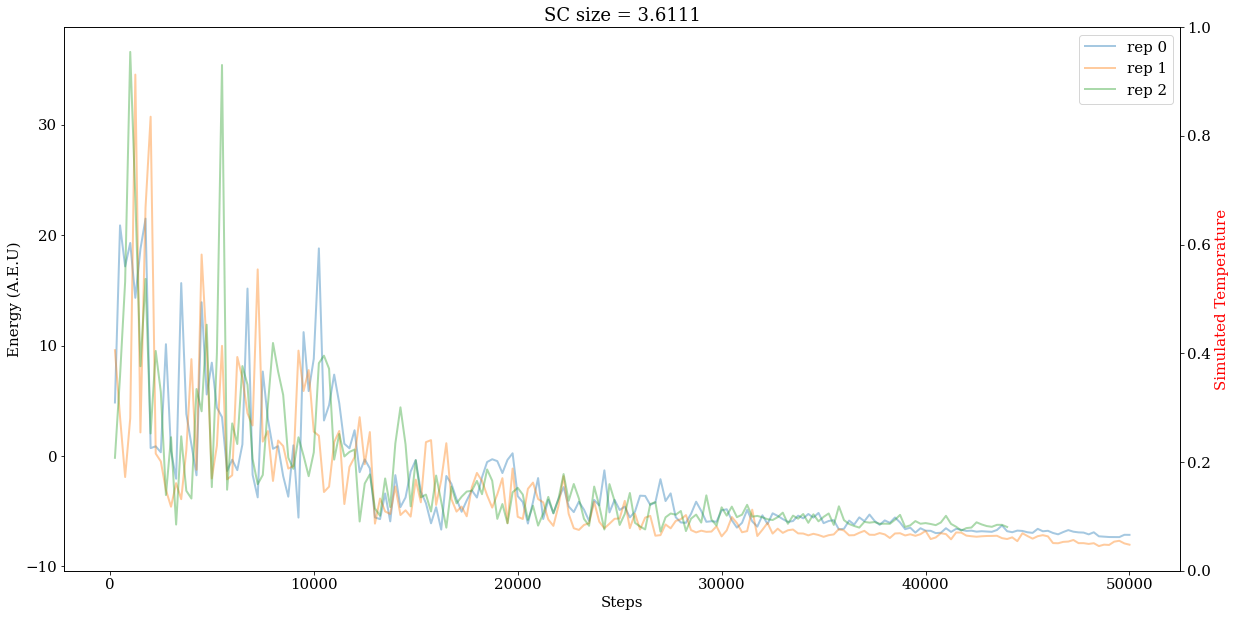

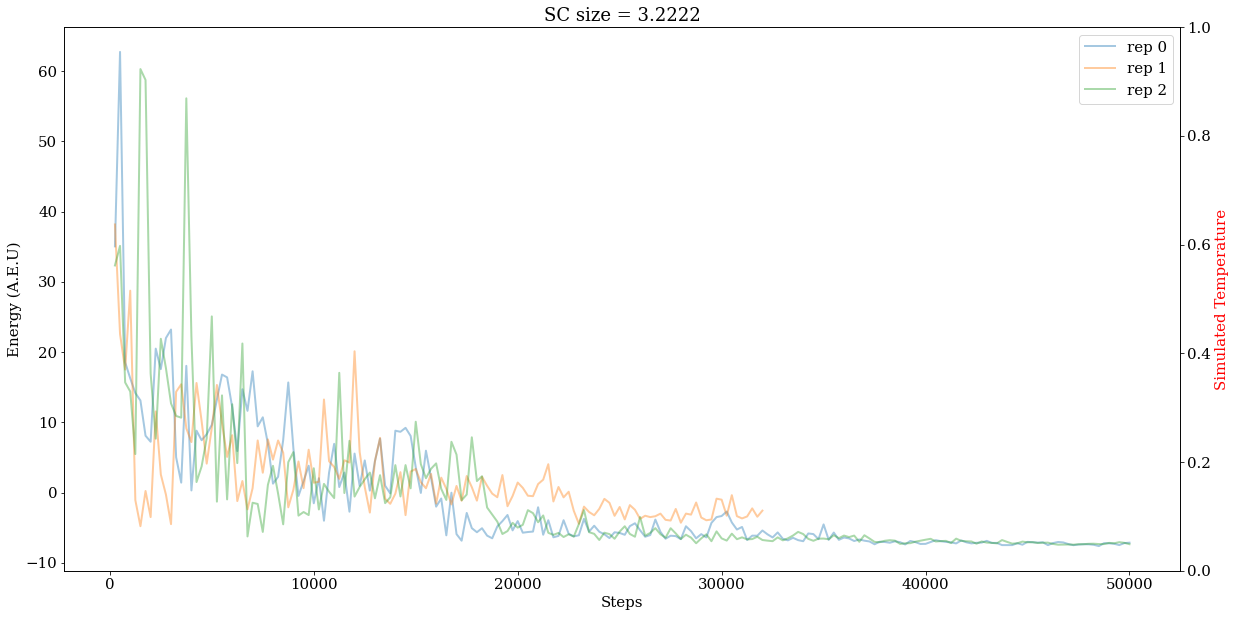

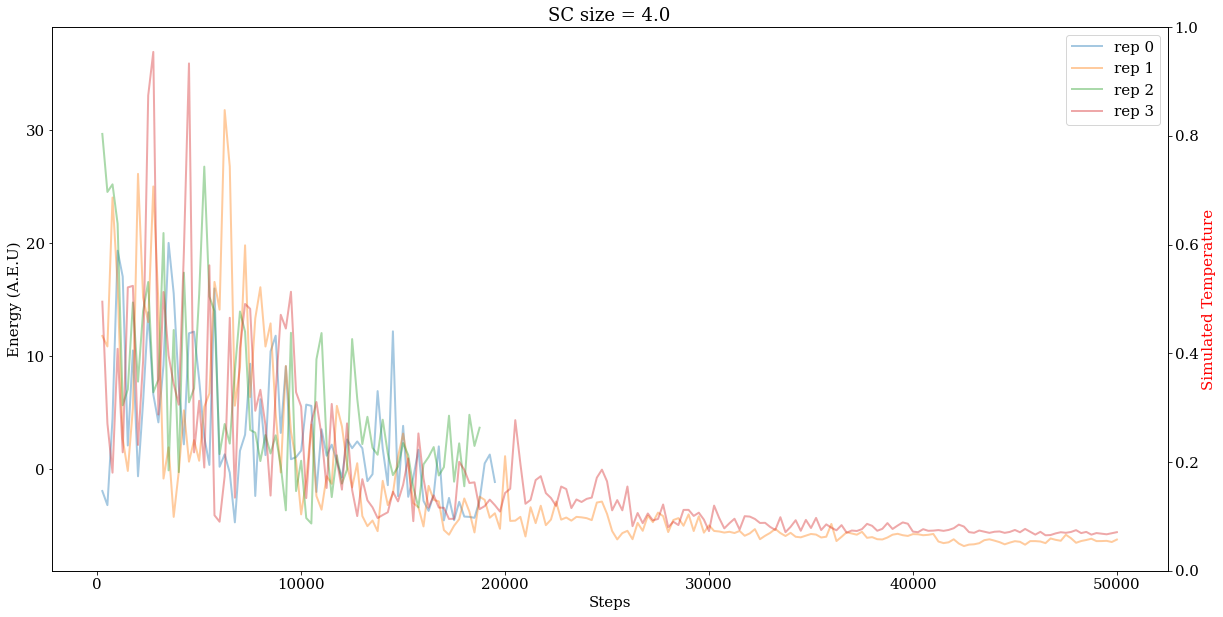

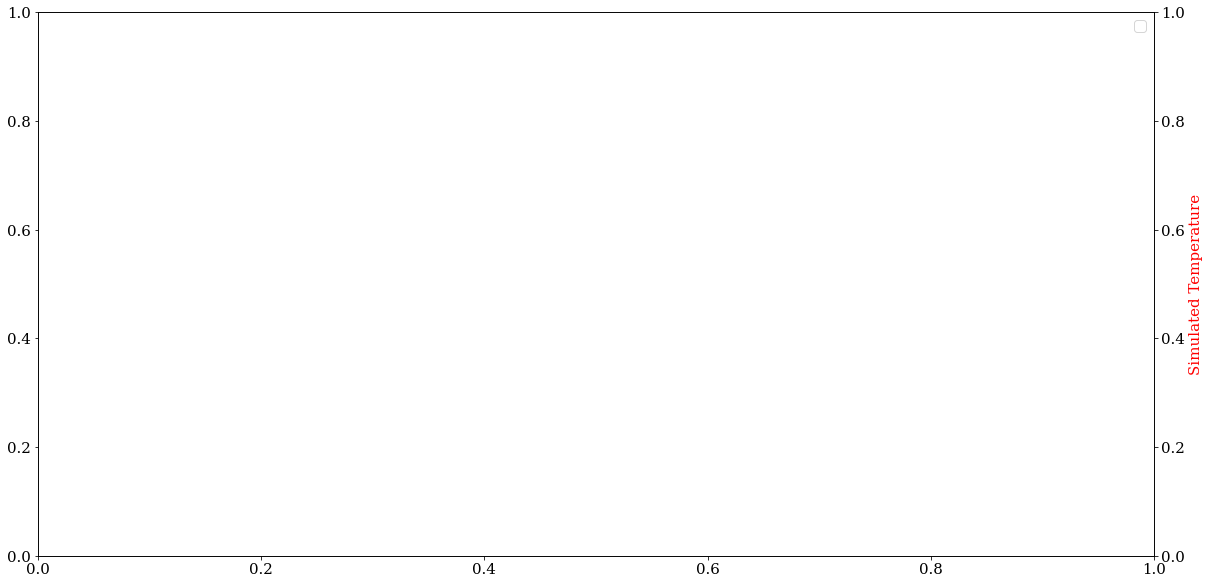

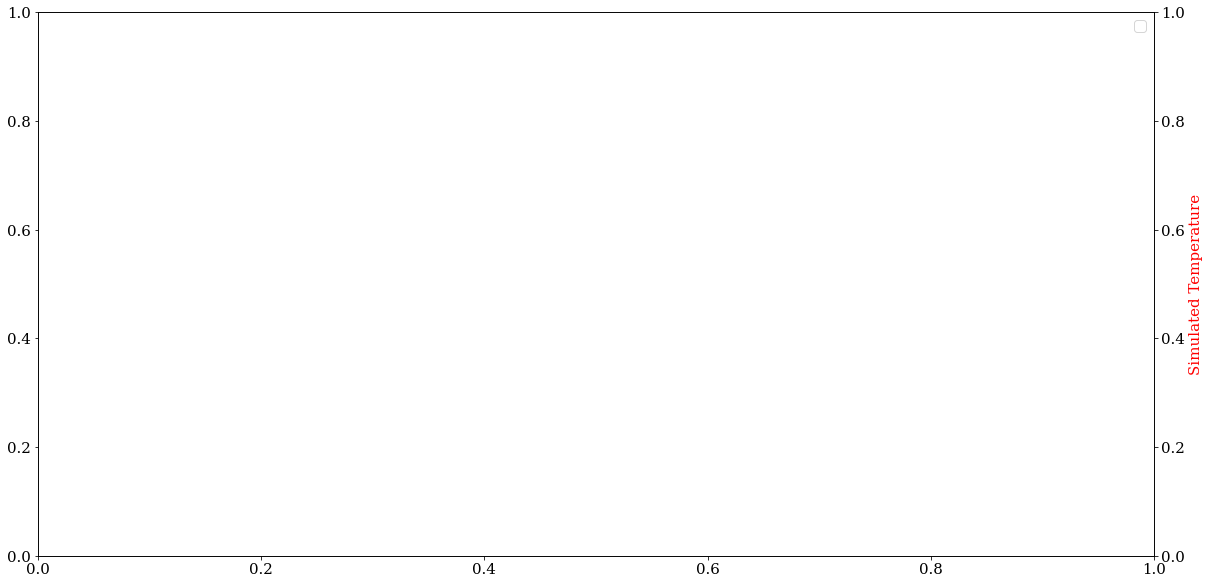

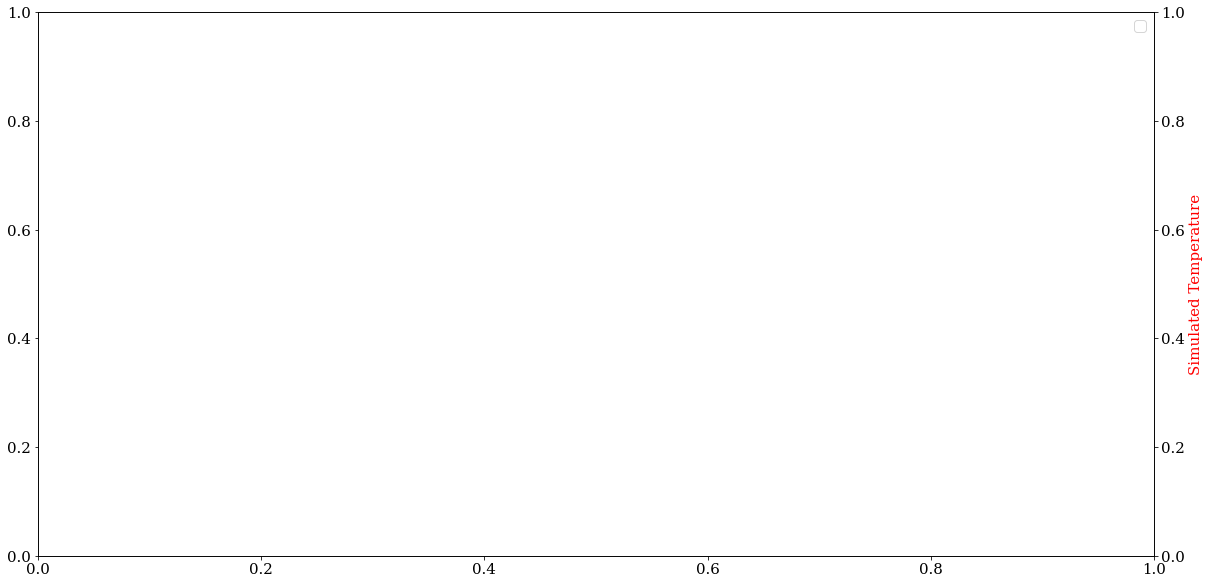

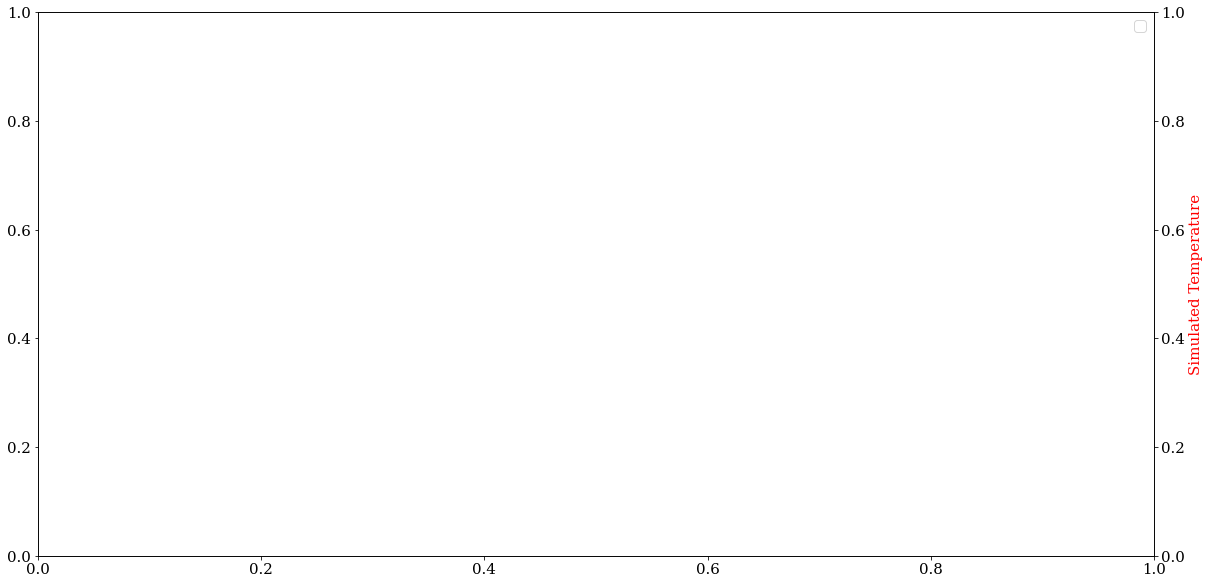

In [108]:
for sc_size in sc_sizes:
    fig, ax1 = plt.subplots(1,1,figsize = [20,10])
    ax2 = ax1.twinx()
    # ax2.plot(out_steps, kts, 'r')
    # ax2.set_xlim([0, 500000])
    ax2.set_ylabel("Simulated Temperature", color = 'r')
    for job in project.find_jobs({'sc_size':sc_size}):
        energy_file = job.fn("energies.txt")
        if os.path.isfile(energy_file):
            energies = pd.read_csv(energy_file, header=None)
            ax1.plot(energies.values[:,0], energies.values[:,1], alpha = .4, lw=2)
            ax1.set_xlabel("Steps")
            ax1.set_ylabel("Energy (A.E.U)")
            # ax1.set_xlim([0, 500000])
            ax1.set_title("SC size = " + str(round(job.sp['sc_size'],4)))
        else:
            print("sc_size", sc_size, "hasn't started yet")
    
    ax1.legend(["rep " + str(k) for k in range(10)])
    


In [82]:
# RMSD (to mediod centers) vs Energy
sc_sizes = [1.0]

n_clusters = 2
avg_cluster_scores = []
for sc_size in sc_sizes:
    plt.figure()
    traj_file_name_list = []
    all_energies = []
    for job in project.find_jobs({'sc_size':sc_size}):
            energy_file = job.fn("energies.txt")
            if os.path.isfile(energy_file):
                energies = pd.read_csv(energy_file, header=None)
                all_energies.extend(energies.values[:, 1])
                structure_file = job.fn("structure.txt")
                struct_loc = pd.read_csv(structure_file, header=None)
                traj_file_name_list.extend([job.fn(file) for file in struct_loc[1].values])
            else:
                print("sc_size", sc_size, "hasn't started yet")
    traj = md.load(traj_file_name_list)
    medoid_positions, cluster_sizes, cluster_rmsd, cluster_indices, silhouette_avg = analyze_foldamers.cluster.\
    get_cluster_medoid_positions_KMedoids(traj_file_name_list, n_clusters = n_clusters, output_dir="cluster_output", cgmodel=None, plot_silhouette=True)
    traj.save_pdb("test.pdb")
    

ValueError: No trajectories specified. filename_or_filenames was an empty list

<Figure size 432x288 with 0 Axes>

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

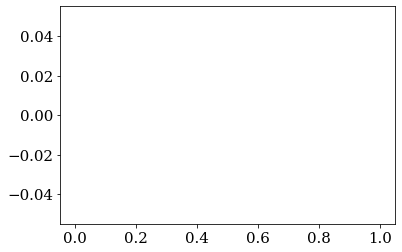

In [9]:
# Distribution of minimum energy structures
sorted_energies = copy.deepcopy(all_energies)
sorted_energies.sort()
plt.hist(sorted_energies[:1000], bins=30)

In [ ]:
silhouette_avg

In [ ]:
plt.figure()
for i in range(n_clusters):
    medoid_mdtraj = md.load("cluster_output/medoid_" + str(i) + ".pdb")
    rmsds_medoid_i = md.rmsd(traj, medoid_mdtraj)
    plt.scatter(rmsds_medoid_i[cluster_indices[i]], [all_energies[a] for a in cluster_indices[i]], s = 1)
    plt.xlabel("RMSD to Mediod " + str(i+1))
    plt.ylabel("Energies")
    plt.title(job.sp)
plt.legend(["cluster " + str(i + 1) for i in range(n_clusters)])
plt.savefig(job.fn("kmedoid_rmsd_energy_scatter.jpg"), dpi=600)
    

In [ ]:
legend_list.extend(["Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
len(legend_list)

In [8]:
# RMSD (to minimum energy structure) vs Energy

for sc_size in sc_sizes:
    plt.figure(figsize = [20,10])
    all_traj = md.load(traj_file_name_list)

    for job in project.find_jobs({'sc_size':sc_size}):
        # Get MC traj
        structure_file = job.fn("structure.txt")
        struct_loc = pd.read_csv(structure_file, header=None)
        traj = md.load([job.fn(file) for file in struct_loc[1].values])

        # Get minimum energy structure
        energy_file = job.fn("energies.txt")
        energies = pd.read_csv(energy_file, header=None).values[:,1]
        
        min_energy_index = np.where(all_energies == np.min(all_energies))
        min_energy_struct = all_traj.slice(min_energy_index)

        # Compute RMSDs to trajectory
        rmsds_medoid_i = md.rmsd(traj, min_energy_struct)

        plt.scatter(rmsds_medoid_i, energies, s = 1)
        
        
        
    # Get ALL MC traj
    structure_file = job.fn("structure.txt")
    struct_loc = pd.read_csv(structure_file, header=None)
    traj = md.load(traj_file_name_list)

    # Get minimum energy structure
    min_energy_index= np.where(all_energies == np.min(all_energies))
    min_energy_struct = traj.slice(min_energy_index)

    # Compute RMSDs to trajectory
    rmsds_medoid_i = md.rmsd(traj, min_energy_struct)
    
    # plt.figure(figsize = [20,10])
    # plt.scatter(rmsds_medoid_i, all_energies, s = 1)

        
    # Minimum energy structure
    
    minimum_index = min_energy_index[0][0]
    poi_1 = np.where(all_energies == sorted_energies[450])[0][0]
    poi_2 = np.where(all_energies == sorted_energies[471])[0][0]
    poi_3 = np.where(all_energies == sorted_energies[1400])[0][0]
    poi_4 = np.where(all_energies == sorted_energies[2300])[0][0]
    poi_5 = np.where(all_energies == sorted_energies[700])[0][0]
    
    min_energy_struct.save_pdb("overall_minimim.pdb")
    plt.scatter(rmsds_medoid_i[minimum_index], all_energies[minimum_index], c = 'r', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_1], all_energies[poi_1], c = 'g', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_2], all_energies[poi_2], c = 'y', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_3], all_energies[poi_3], c = 'k', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_4], all_energies[poi_4], c = 'm', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_5], all_energies[poi_5], c = 'C1', s = 150, marker = 'D')
    legend_list = ["rep " + str(i) for i in range(10)]
    legend_list.extend(["Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
    plt.legend(legend_list)
    plt.xlabel("RMSD to Minimum Energy Structure")
    plt.ylabel("Energies")
    plt.savefig("min_energy_rmsd_energy_scatter.jpg", dpi=600)



NameError: name 'traj_file_name_list' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
# Minimum energy structure

minimum_index = min_energy_index[0][0]
poi_1 = np.where(all_energies == sorted_energies[450])[0][0]
poi_2 = np.where(all_energies == sorted_energies[471])[0][0]
poi_3 = np.where(all_energies == sorted_energies[1400])[0][0]
poi_4 = np.where(all_energies == sorted_energies[2300])[0][0]
poi_5 = np.where(all_energies == sorted_energies[700])[0][0]

print("Minimum energy structure location:", traj_file_name_list[minimum_index])
print("Point of Interest 1 location:", traj_file_name_list[poi_1])
print("Point of Interest 2 location:", traj_file_name_list[poi_2])
print("Point of Interest 3 location:", traj_file_name_list[poi_3])
print("Point of Interest 4 location:", traj_file_name_list[poi_4])
print("Point of Interest 5 location:", traj_file_name_list[poi_5])



min_energy_struct.save_pdb("overall_minimim.pdb")
plt.figure(figsize = [20,10])
plt.scatter(rmsds_medoid_i, all_energies, s = 10, label = None)
plt.scatter(rmsds_medoid_i[minimum_index], all_energies[minimum_index], c = 'r', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_1], all_energies[poi_1], c = 'g', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_2], all_energies[poi_2], c = 'y', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_3], all_energies[poi_3], c = 'k', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_4], all_energies[poi_4], c = 'm', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_5], all_energies[poi_5], c = 'C1', s = 150, marker = 'D')
plt.legend(["All structures", "Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
plt.xlabel("RMSD to Minimum Energy Structure")
plt.ylabel("Energy (A.E.U)")
plt.savefig("min_energy_rmsd_energy_scatter.jpg", dpi=600)

In [ ]:
rmsd_matrix = np.zeros([traj.n_frames, traj.n_frames])
for i in range(traj.n_frames):
    rmsd_matrix[:, i] = md.rmsd(traj, traj.slice(i))

In [ ]:
plt.hist(rmsd_matrix.flatten(), bins = 100)
plt.ylabel("Count")
plt.xlabel("RMSDs")